In [1]:

# Import libraries
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
import cplex as cpx
import scipy.stats as scs
import matplotlib as mpl
import math
import cvxpy as cp
import statsmodels.api as sm
%matplotlib inline

# Import other libraries
# Insert your code here #

In [2]:
# Read Daily Prices

# CSV file with price data
input_file_prices  = 'Daily_closing_prices.csv'
if path.exists(input_file_prices):
    print('\nReading daily prices datafile - {}\n'.format(input_file_prices))
    fid = pd.read_csv(input_file_prices)
    # instrument tickers
    tickers = list(fid.columns)[1:]
    # time periods
    dates = fid['Date']
    data_prices = fid.values[:,1:]
else:
    print("No such file '{}'".format(input_file_prices), file=sys.stderr)
    
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(fid['Date'].apply(convert_date_to_array)))


Reading daily prices datafile - Daily_closing_prices.csv



# Question 1 

## Part 1

In [3]:
# Question 1 pt1 

# Specify quantile level for VaR/CVaR
alf = 0.95

# Number of assets in universe
Na = data_prices.shape[1]

# Number of historical scenarios
Ns = data_prices.shape[0]

# Positions in the portfolio
positions = np.array([100, 0, 0, 0, 0, 0, 0, 0, 200, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(Na,1)

dp_1 = data_prices[1:, :]
dp_2 = data_prices[0:-1, :]
pl_data1 = dp_1 - dp_2 
p_pl_1 = (positions.T*pl_data1).sum(axis =1 )
loss_1d =np.sort(-p_pl_1)
N1 = len(loss_1d)
VaR1 = loss_1d[int(math.ceil(N1 * alf))-1]
CVaR1 = (1 / (N1 * (1 - alf))) * ((math.ceil(N1 * alf) - N1 * alf) * VaR1 + sum(loss_1d[int(math.ceil(N1 * alf)):]))
VaR1n = np.mean(loss_1d) + scs.norm.ppf(alf)*np.std(loss_1d)
CVaR1n = np.mean(loss_1d) + (scs.norm.pdf(scs.norm.ppf(alf))/ (1-alf)) *np.std(loss_1d)

# 10 days 
dp_3 = data_prices[10:, :]
dp_4 = data_prices[0:-10, :]
pl_data10 = dp_3 - dp_4 
p_pl_10 = (positions.T*pl_data10).sum(axis =1 )
loss_10d =np.sort(-p_pl_10)
N10 = len(loss_10d)
VaR10 = loss_10d[int(math.ceil(N10 * alf))-1]
CVaR10 = (1 / (N10 * (1 - alf))) * ((math.ceil(N10 * alf) - N10 * alf) * VaR10 + sum(loss_10d[int(math.ceil(N10 * alf)):]))
VaR10n = np.mean(loss_10d) + scs.norm.ppf(alf)*np.std(loss_10d)
CVaR10n = np.mean(loss_10d) + (scs.norm.pdf(scs.norm.ppf(alf))/ (1-alf)) *np.std(loss_10d)

################################ Insert your code here ################################


print('Historical 1-day VaR %4.1f%% = $%6.2f,   Historical 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1, 100*alf, CVaR1))
print('    Normal 1-day VaR %4.1f%% = $%6.2f,       Normal 1-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR1n, 100*alf, CVaR1n))
print('Historical 10-day VaR %4.1f%% = $%6.2f,   Historical 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10, 100*alf, CVaR10))
print('    Normal 10-day VaR %4.1f%% = $%6.2f,       Normal 10-day CVaR %4.1f%% = $%6.2f\n'% (100*alf, VaR10n, 100*alf, CVaR10n))

print('Does VaR (10 day) = 10 * VaR (one day) : ', (VaR1*10) == VaR10)
print('\nDoes CVaR (10 day) = 10 * CVaR (one day) : ',(CVaR1*10) == CVaR10 )
print('\nThe Difference for VaR is: $',(VaR10 - VaR1*10))
print('\nThe Difference for CVaR is: $',(CVaR10 - (CVaR1*10)))

Historical 1-day VaR 95.0% = $2477.25,   Historical 1-day CVaR 95.0% = $4326.98

    Normal 1-day VaR 95.0% = $2646.49,       Normal 1-day CVaR 95.0% = $3339.94

Historical 10-day VaR 95.0% = $9023.03,   Historical 10-day CVaR 95.0% = $14099.34

    Normal 10-day VaR 95.0% = $7331.15,       Normal 10-day CVaR 95.0% = $9396.60

Does VaR (10 day) = 10 * VaR (one day) :  False

Does CVaR (10 day) = 10 * CVaR (one day) :  False

The Difference for VaR is: $ -15749.49260999996

The Difference for CVaR is: $ -29170.473228734496


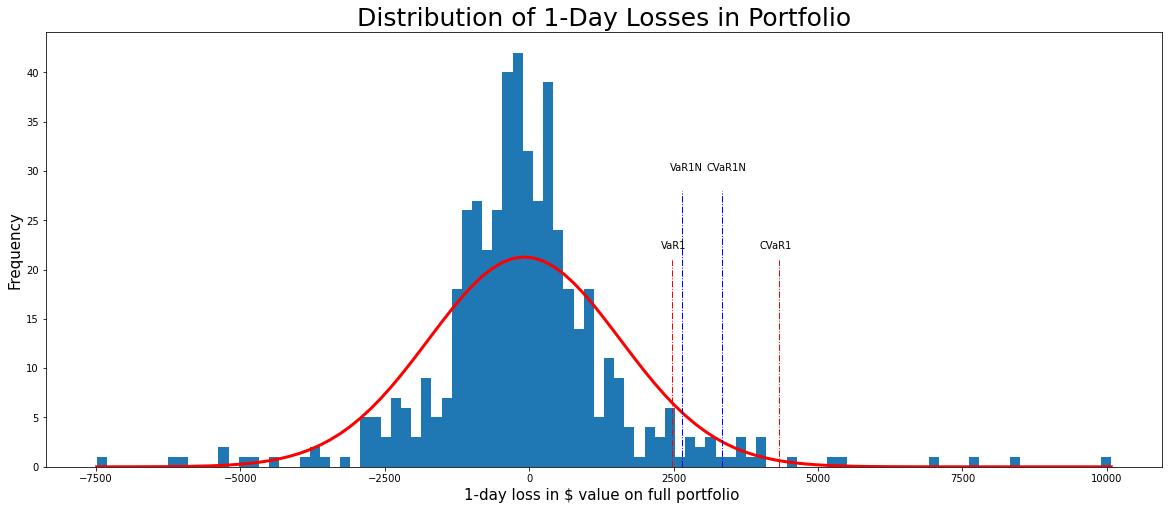

In [4]:
#plot 1 day 
plt.figure(figsize=(20,8))
frequencyCounts, binLocations, patches = plt.hist(loss_1d, 100)
normf = (1 / (np.std(loss_1d) * math.sqrt(2 * math.pi))) * np.exp((-0.5 * ((binLocations - np.mean(loss_1d)) / np.std(loss_1d)) ** 2).astype(float))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([CVaR1, CVaR1], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaR1, VaR1], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.92 * VaR1, max(frequencyCounts) / 1.9, 'VaR1')
plt.text(0.92 * CVaR1, max(frequencyCounts) / 1.9, 'CVaR1')

plt.plot([CVaR1n, CVaR1n], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([VaR1n, VaR1n], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * VaR1n, max(frequencyCounts) / 1.4, 'VaR1N')
plt.text(0.92 * CVaR1n, max(frequencyCounts) / 1.4, 'CVaR1N')

plt.title('Distribution of 1-Day Losses in Portfolio', fontsize = 25)
plt.xlabel('1-day loss in $ value on full portfolio ', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.draw()

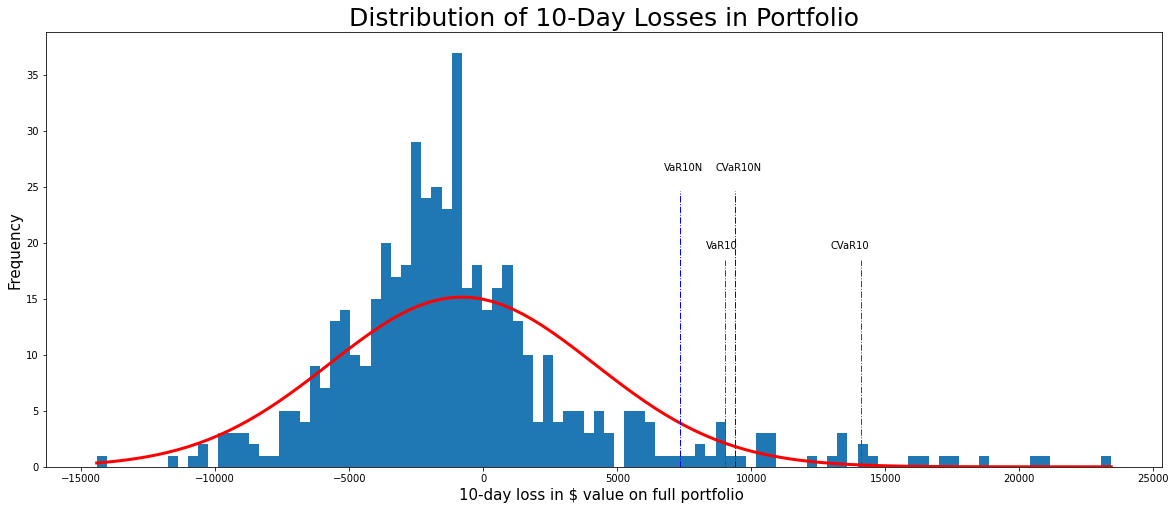

In [5]:
#plot 10 day 
plt.figure(figsize=(20,8))
frequencyCounts, binLocations, patches = plt.hist(loss_10d, 100)
normf = (1 / (np.std(loss_10d) * math.sqrt(2 * math.pi))) * np.exp((-0.5 * ((binLocations - np.mean(loss_10d)) / np.std(loss_10d)) ** 2).astype(float))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([CVaR10, CVaR10], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')
plt.plot([VaR10, VaR10], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.92 * VaR10, max(frequencyCounts) / 1.9, 'VaR10')
plt.text(0.92 * CVaR10, max(frequencyCounts) / 1.9, 'CVaR10')

plt.plot([CVaR10n, CVaR10n], [0, max(frequencyCounts) / 1.5], color='b', linewidth=1, linestyle='-.')
plt.plot([VaR10n, VaR10n], [0, max(frequencyCounts)/1.5], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * VaR10n, max(frequencyCounts) / 1.4, 'VaR10N')
plt.text(0.92 * CVaR10n, max(frequencyCounts) / 1.4, 'CVaR10N')

plt.title('Distribution of 10-Day Losses in Portfolio', fontsize = 25)
plt.xlabel('10-day loss in $ value on full portfolio ', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.draw()

## Part 2

In [6]:
#Question 1 part 2 
#compute 1 day VaR for each stock holding

# MSFT 
p_loss_1d = positions.T*pl_data1
loss_1d_msft = np.sort(-p_loss_1d[:, 0])
loss_1d_aapl = np.sort(-p_loss_1d[:, 8])
loss_1d_ibm  = np.sort(-p_loss_1d[:, 9])

VaR1_msft = loss_1d_msft[int(math.ceil(N1 * alf))-1]
VaR1_aapl = loss_1d_aapl[int(math.ceil(N1 * alf))-1]
VaR1_ibm  = loss_1d_ibm[int(math.ceil(N1 * alf))-1]

print('Historical 1-day VaR for portfolio %4.1f%% = $%6.2f\n' % (100*alf, VaR1))
print('Historical 1-day VaR for MSFT %4.1f%% = $%6.2f\n' % (100*alf, VaR1_msft))
print('Historical 1-day VaR for AAPL %4.1f%% = $%6.2f\n' % (100*alf, VaR1_aapl))
print('Historical 1-day VaR for IBM %4.1f%% = $%6.2f\n' % (100*alf, VaR1_ibm))

print('Does VaR(Portfolio) = VaR(MSFT) + VaR(AAPL) + VaR(IBM) :', (VaR1 == (VaR1_msft+VaR1_aapl+VaR1_ibm)))
print('\nThe difference is: $',(VaR1 - (VaR1_msft+VaR1_aapl+VaR1_ibm)))

Historical 1-day VaR for portfolio 95.0% = $2477.25

Historical 1-day VaR for MSFT 95.0% = $531.61

Historical 1-day VaR for AAPL 95.0% = $564.25

Historical 1-day VaR for IBM 95.0% = $1837.73

Does VaR(Portfolio) = VaR(MSFT) + VaR(AAPL) + VaR(IBM) : False

The difference is: $ -456.3316459999978


In [7]:
VaR1n_msft = np.mean(loss_1d_msft) + scs.norm.ppf(alf)*np.std(loss_1d_msft)
VaR1n_aapl = np.mean(loss_1d_aapl) + scs.norm.ppf(alf)*np.std(loss_1d_aapl)
VaR1n_ibm  = np.mean(loss_1d_ibm)  + scs.norm.ppf(alf)*np.std(loss_1d_ibm)

print('Normal 1-day VaR for portfolio %4.1f%% = $%6.2f\n' % (100*alf, VaR1n))
print('Normal 1-day VaR for MSFT %4.1f%% = $%6.2f\n' % (100*alf, VaR1n_msft))
print('Normal 1-day VaR for AAPL %4.1f%% = $%6.2f\n' % (100*alf, VaR1n_aapl))
print('Normal 1-day VaR for IBM %4.1f%% = $%6.2f\n' % (100*alf, VaR1n_ibm))

print('Does VaRn(Portfolio) = VaRn(MSFT) + VaRn(AAPL) + VaRn(IBM) :', (VaR1n == (VaR1n_msft+VaR1n_aapl+VaR1n_ibm)))
print('\nThe difference is: $', (VaR1n - (VaR1n_msft+VaR1n_aapl+VaR1n_ibm)))

Normal 1-day VaR for portfolio 95.0% = $2646.49

Normal 1-day VaR for MSFT 95.0% = $556.21

Normal 1-day VaR for AAPL 95.0% = $592.79

Normal 1-day VaR for IBM 95.0% = $1936.14

Does VaRn(Portfolio) = VaRn(MSFT) + VaRn(AAPL) + VaRn(IBM) : False

The difference is: $ -438.6515478974943


# Question 2

## Part 1
Compute and plot in the (expected daily return, std deviation of daily return) space:
1. Minimum variance portfolio of risky assets under no-short-sales constraint;
2. Maximum return portfolio of risky assets under no-short-sales constraint;
3. Efficient frontier of risky assets under no-short-sales constraint;
4. Equally-weighted (1=N) portfolio of risky assets;
5. Initial portfolio from Assignment 1;
6. Maximum Sharpe ratio portfolio under no-short-sales constraint;
7. Risk-free asset;
8. Efficient frontier of all assets including risk-free asset, if shorting of risk-free asset is allowed but shorting of maximum Sharpe ratio portfolio is prohibited (tangent line).

In [8]:
init_value = np.dot(data_prices[0,:], positions)
init_value = init_value[0]
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 69802.16



In [9]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Compute means and covariances for Question 2 (2019 and 2020)
cur_returns = data_prices[1:,:] / data_prices[:Ns-1,:] - 1
cur_returns = cur_returns

# Expected returns for Question 2
mu = np.mean(cur_returns, axis=0).reshape(cur_returns.shape[1],1)
# Covariances for Question 2
Q = np.cov(cur_returns.astype(float).T)

#### 1) Minimum Variance, No-shorting 

In [10]:
#strategy 2: Min Variance, no shorting
w_s1 = cp.Variable(Na)
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w_s1, Q)),
                 [sum(w_s1) == 1,
                  w_s1 >= 0])
prob1.solve(solver=cp.CPLEX, verbose=True,cplex_params={"qpmethod": 6})

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.03 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  Total non-zeros in factor = 210
  Total FP ops to factor    = 2870
Tried aggregator 1 time.
QP Presolve eliminated 20 rows and 0 columns.
Number of nonzeros in lower triangle of Q = 190
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.00 ticks)
Summary statistics for factor of Q:
  Rows in Factor            = 20
  Integer space required    = 20
  T

0.00014724575648841358

In [11]:
w_s1 = w_s1.value
var_s1 = np.dot(w_s1, np.dot(Q, w_s1))
ret_s1 = np.dot(mu[:,0], w_s1)
print('Minimum Variance Portfolio:')
print('Expected Daily Return = ', ret_s1)
print('             Variance = ', var_s1)
print('   Standard Deviation = ', np.sqrt(var_s1))

Minimum Variance Portfolio:
Expected Daily Return =  0.0007054004609645362
             Variance =  0.00014724575648841358
   Standard Deviation =  0.012134486247403042


#### 2) Maximum Return, No-shorting 

In [12]:
#strategy 3: Max Return No shorting  
w_s2 = cp.Variable(Na)
prob2 = cp.Problem(cp.Maximize(mu.T@w_s2),
                 [sum(w_s2) == 1,
                  w_s2 >= 0])
prob2.solve(solver=cp.CPLEX, verbose=True,cplex_params={"qpmethod": 6})

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_QPMethod                                6
Tried aggregator 1 time.
LP Presolve eliminated 21 rows and 20 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)


0.0037921461229095984

In [13]:
w_s2 = w_s2.value
var_s2 = np.dot(w_s2, np.dot(Q, w_s2))
ret_s2 = np.dot(mu[:,0], w_s2)
print('Maximum Return Portfolio:')
print('Expected Daily Return = ', ret_s2)
print('             Variance = ', var_s2)
print('   Standard Deviation = ', np.sqrt(var_s2))

Maximum Return Portfolio:
Expected Daily Return =  0.0037921461229095984
             Variance =  0.0013160293025746026
   Standard Deviation =  0.03627711816799403


#### 3) Efficient Frontier, No-shorting 

In [14]:
#stratgy 3: Efficient Frontier, no shorting
targetRet = np.linspace(ret_s1,ret_s2,50)
w_s3 = cp.Variable(Na)
eps = cp.Parameter()
#target return: between min var return and max return
eps.value = targetRet[24]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w_s3, Q)),
                 [mu.T@w_s3 >= eps,
                  sum(w_s3) == 1,
                  w_s3 >= 0])
prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})


0.00034092195140401536

In [15]:
w_ef = w_s3.value
var_ef = np.dot(w_ef, np.dot(Q, w_ef))
ret_ef = np.dot(mu[:,0], w_ef)
print('Efficient Frontier Portfolio:')
print('Expected Daily Return = ', ret_ef)
print('             Variance = ', var_ef)
print('   Standard Deviation = ', np.sqrt(var_ef))

Efficient Frontier Portfolio:
Expected Daily Return =  0.0022172758872233416
             Variance =  0.0003409219514040153
   Standard Deviation =  0.01846407190746438


In [16]:
w_front = []
var_front = []
ret_front = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve(solver=cp.CPLEX, verbose=False,cplex_params={"qpmethod": 6})
    w_front.append(w_s3.value)
    var_front.append(np.dot(w_s3.value, np.dot(Q, w_s3.value)))
    ret_front.append(np.dot(mu[:,0], w_s3.value))

In [17]:
# #plot ef
# ax = plt.gca()
# plt.rcParams['figure.figsize'] = [10, 5]
# #plt.rcParams['figure.dpi'] = 200
    
# # Plot volatility versus expected return for minimum variance portfolio
# ax.scatter(x=np.sqrt(var_s1), y=ret_s1, marker='D', s=50,  color='DarkGreen', label='minimum variance portfolio')

# # Plot volatility versus expected return for maximum return portfolio
# ax.scatter(x=np.sqrt(var_s2), y=ret_s2,  marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')

# # Plot efficient frontier
# ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')

# # Plot volatility versus expected return for individual stocks
# ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='Blue', label='individual stocks')

# # Format and display the final plot
# ax.axis([0.9*np.sqrt(var_s1), 1.2*np.max(np.sqrt(np.diag(Q))), np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_s2])
# ax.set_xlabel('Volatility (Standard Deviation)')
# ax.set_ylabel('Expected Return')
# plt.title('Efficient Frontier')
# ax.legend(loc="lower right")
# ax.grid()
# plt.show()

#### 4) 1/N Equally Weighted 

In [18]:
# strategy 4: 1/N
w_s4 = np.empty(Na)
w_s4.fill(1/Na)
var_s4 = np.dot(w_s4, np.dot(Q,w_s4))
ret_s4 = np.dot(mu[:,0], w_s4)
print('1/N Portfolio:')
print('Expected Daily Return = ', ret_s4)
print('             Variance = ', var_s4)
print('   Standard Deviation = ', np.sqrt(var_s4))

1/N Portfolio:
Expected Daily Return =  0.0012723110526728
             Variance =  0.0003624929083287007
   Standard Deviation =  0.01903924652733665


#### 5) Initial Portfolio from Assignment 1

In [19]:
#strategy 5: Initial portfolio from assignment 1
positions_s5 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])
value_s5 = np.dot(positions_s5,data_prices[0])
w_s5 = (positions_s5* data_prices[0])/value_s5
var_s5 = np.dot(w_s5, np.dot(Q,w_s5))
ret_s5 = np.dot(mu[:,0], w_s5)
print('Initial portfolio from assignment 1:')
print('Expected Daily Return = ', ret_s5)
print('             Variance = ', var_s5)
print('   Standard Deviation = ', np.sqrt(var_s5))

Initial portfolio from assignment 1:
Expected Daily Return =  0.0002168389384752773
             Variance =  0.0005249499603611936
   Standard Deviation =  0.022911786494317583


#### 6) Max Sharpe's Ratio

In [47]:
#strategy 6: max sharpe 
n = Na + 1
# daily risk free rate 
daily_rf = 1.025**(1.0/252)-1
r_diff = mu - daily_rf
r_diff = r_diff.astype(float)
#initialize Cplex object
prob6 = cpx.Cplex()
prob6.objective.set_sense(prob6.objective.sense.minimize)
    
#Define linear part of objective function and bounds on variables, no linear part
c = [0.0]*n 
lb = [0.0]*n
cols = []

for i in range(n-1):
    cols.append([[0,1],[r_diff.item(i),1]])
    
cols.append([[0,1],[0,-1]])
var_names = ["y_%s" % i for i in range(1,n)]
var_names.append("k")
    
#add linear obj, constr, lb to model
prob6.linear_constraints.add(rhs=[1.0, 0], senses="EE")
prob6.variables.add(obj=c, lb=lb, columns=cols, names = var_names)
    
#define quad part of obj 
c_k = np.zeros((20,1))        # add a col of 0 coeff for k 
Q_s6 = np.hstack((Q,c_k))
c_k = np.zeros((1,21))        # add a row of 0 coeff for k 
Q_s6 = np.vstack((Q_s6,c_k))
    
qmat =[[list(range(n)),list(2*Q_s6[i,:])] for i in range(n)]
prob6.objective.set_quadratic(qmat)
    
    #set parameters
prob6.parameters.threads.set(4)
prob6.set_results_stream(None)
prob6.set_warning_stream(None)
    
#solve
prob6.solve()
    
#retrieve optimal sol
y_max = prob6.solution.get_values()
y_max = np.asarray(y_max)
kappa = y_max[-1]
y_max = y_max[0:-1]
    
# calculate weight using y 
w_s6 = y_max/kappa

var_s6 = np.dot(w_s6, np.dot(Q,w_s6))
ret_s6 = np.dot(mu[:,0], w_s6)
print('Maximum Sharpe Ratio:')
print('Expected Daily Return = ', ret_s6)
print('             Variance = ', var_s6)
print('   Standard Deviation = ', np.sqrt(var_s6))

Maximum Sharpe Ratio:
Expected Daily Return =  0.002836044560613901
             Variance =  0.0005160195911414756
   Standard Deviation =  0.02271606460506475


#### 7) Risk-free Assets

In [21]:
#stratgy 7: risk free
daily_rf = 1.025**(1.0/252)-1
ret_s7 = daily_rf 
print('Risk-free Portfolio:')
print('Expected Daily Return = ', ret_s6)
print('             Variance =  0', )
print('   Standard Deviation =  0')

Risk-free Portfolio:
Expected Daily Return =  0.002836044560613901
             Variance =  0
   Standard Deviation =  0


#### 8) Efficient Frontier + Risk-free Asset

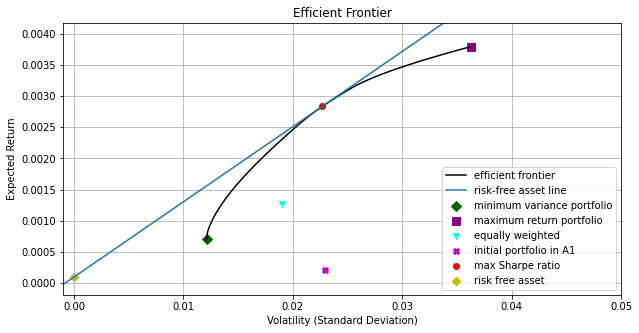

In [51]:
#strategy 8: Efficient Frontier + Rf 
#plot ef
ax = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
#plt.rcParams['figure.dpi'] = 200
    
# Plot volatility versus expected return for minimum variance portfolio
ax.scatter(x=np.sqrt(var_s1), y=ret_s1, marker='D', s=50,  color='DarkGreen', label='minimum variance portfolio')

# Plot volatility versus expected return for maximum return portfolio
ax.scatter(x=np.sqrt(var_s2), y=ret_s2,  marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')

# Plot efficient frontier
ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')


# Plot volatility versus expected return for individual stocks
# ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='Blue', label='individual stocks')

#Plot volatility versus expected return for 1/N
ax.scatter(x=np.sqrt(var_s4), y=ret_s4, marker = 'v', color='cyan', label='equally weighted')

#Plot volatility versus expected return for initial portfolio in assginment 1
ax.scatter(x=np.sqrt(var_s5), y=ret_s5, marker = 'X', color='m', label='initial portfolio in A1')

#Plot volatility versus expected return for max sharpe
ax.scatter(x=np.sqrt(var_s6), y=ret_s6, marker = 'o', color='r', label='max Sharpe ratio')

#Plot volatility versus expected return for risk free
ax.scatter(x=0, y=ret_s7, marker = 'D', color='y', label='risk free asset')

#Plot volatility versus expected return for ef+rf, tangent line
ax.axline([0,daily_rf], [np.sqrt(var_s6), ret_s6], label = 'risk-free asset line')

# Format and display the final plot
ax.axis([-0.001,0.05, np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_s2])
ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
ax.legend(loc="lower right")
ax.grid()
plt.show()

## Part 2
Compute and plot in the (expected daily return, std deviation of daily return) space:
1. Efficient frontier of risky assets under no-short-sales constraint;
2. Individual risky assets;
3. Randomly generated 1000 portfolios under no-short-sales restriction.


### 1) Efficient Frontier

In [23]:
# ef 
w_ef = w_s3.value
var_ef = np.dot(w_ef, np.dot(Q, w_ef))
ret_ef = np.dot(mu[:,0], w_ef)
print('Efficient Frontier Portfolio:')
print('Expected Daily Return = ', ret_ef)
print('             Variance = ', var_ef)
print('   Standard Deviation = ', np.sqrt(var_ef))

Efficient Frontier Portfolio:
Expected Daily Return =  0.0037921461229096
             Variance =  0.0013160293025746039
   Standard Deviation =  0.036277118167994046


In [24]:
var_stocks = np.diag(Q)
ret_stocks = mu 
stock_names = np.array(fid.columns).astype(str)
stock_names = np.delete(stock_names,0)
stock_names.shape

for i in range(len(var_stocks)):
    print(stock_names[i], 'Only Portfolio:')
    print('Expected Daily Return = ', ret_stocks.item(i))
    print('             Variance = ', var_stocks[i])
    print('   Standard Deviation = ', np.sqrt(var_stocks[i]), '\n')


MSFT Only Portfolio:
Expected Daily Return =  0.0018457979844508077
             Variance =  0.00046064422033872363
   Standard Deviation =  0.021462623799030807 

F Only Portfolio:
Expected Daily Return =  0.0007558533373962707
             Variance =  0.0007788398488431351
   Standard Deviation =  0.027907702321100087 

JPM Only Portfolio:
Expected Daily Return =  0.0009474343224944809
             Variance =  0.0006564667072847781
   Standard Deviation =  0.025621606258874132 

GOOG Only Portfolio:
Expected Daily Return =  0.0012275458023695042
             Variance =  0.0004072153241672979
   Standard Deviation =  0.020179576907539413 

HPQ Only Portfolio:
Expected Daily Return =  0.0008903419094523814
             Variance =  0.0007894100981731359
   Standard Deviation =  0.0280964428028378 

C Only Portfolio:
Expected Daily Return =  0.0009273909357525166
             Variance =  0.0010188914462825303
   Standard Deviation =  0.03192007904568111 

HOG Only Portfolio:
Expected Dai

### 3) Randomly Generated 1000 Portfolio, no-shorting

In [75]:
nums = np.random.choice([0, 1],size = 1000, p=[.15, .85])

In [76]:
ret_rand_list = []
var_rand_list = []
w_rand_list = []
Nsim = 1000
for i in range(Nsim):
    w_rand = np.random.uniform(0,1, Na)
    if nums[i] == 0:
        notbuy= np.random.choice(np.arange(0,20),size = 10, p=[0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
        for j in range(len(notbuy)):
            w_rand[notbuy[j]] = 0
    w_rand = w_rand/sum(w_rand)
    w_rand_list.append(w_rand)
    ret_rand = np.dot(mu[:,0], w_rand)
    var_rand = np.dot(w_rand, np.dot(Q,w_rand))
    ret_rand_list.append(ret_rand)
    var_rand_list.append(var_rand)
    
len(ret_rand_list), len(var_rand_list)

(1000, 1000)

In [77]:
np.sum(w_rand_list)

999.9999999999999

In [78]:
ret_rand_list = np.asarray(ret_rand_list)
var_rand_list = np.asarray(var_rand_list)

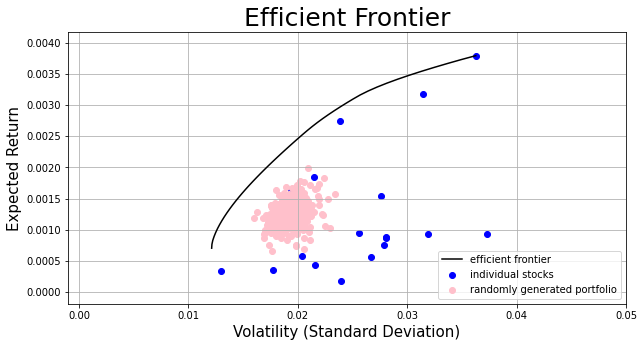

In [79]:
#plot 
ax = plt.gca()
plt.rcParams['figure.figsize'] = [10, 5]
#plt.rcParams['figure.dpi'] = 200
    
# Plot efficient frontier
ax.plot(np.sqrt(var_front), ret_front, 'k-', label='efficient frontier')

# Plot volatility versus expected return for individual stocks
ax.scatter(x=np.sqrt(var_stocks), y=ret_stocks, color='Blue', label='individual stocks')

#Plot volatility versus expected return for 1000 randomly generated portfolio 
ax.scatter(x=np.sqrt(var_rand_list), y=ret_rand_list, color='pink', label='randomly generated portfolio')

ax.axis([-0.001, 0.05, np.min(mu)-0.1*(np.max(mu)-np.min(mu)), 1.1*ret_s2])
ax.set_xlabel('Volatility (Standard Deviation)', fontsize = 15)
ax.set_ylabel('Expected Return', fontsize = 15)
plt.title('Efficient Frontier', fontsize = 25)
ax.legend(loc="lower right")
ax.grid()
plt.show()

# Question 3

In [29]:
# Question 3

# Import FF models data from 2019-01-03 to 2020-12-31
input_file_factors  = 'Daily_FF_factors.csv'
if path.exists(input_file_factors):
    print('\nReading daily FF factors datafile - {}\n'.format(input_file_factors))
    ff_data = pd.read_csv(input_file_factors)
    factors_name = list(ff_data.columns)[1:-1]
    rf      = ff_data['RF'][1:]
    factors = ff_data.values[1:,1:4]
else:
    print("No such file '{}'".format(input_file_factors), file=sys.stderr)

# Indicides helpful to seperate data
# dates[day_ind_start_2019] = '01/02/2019',
# dates[day_ind_end_2019] = '12/31/2019',
# dates[day_ind_start_2019] = '01/02/2020',
# dates[day_ind_end_2019] = '12/31/2019'.
day_ind_start_2019 = 0
day_ind_end_2019   = 251
day_ind_start_2020 = 252
day_ind_end_2020   = 504

data_prices_2019   = data_prices[day_ind_start_2019:day_ind_end_2019+1]
data_prices_2020   = data_prices[day_ind_start_2020:day_ind_end_2020+1]


################################ Insert your code here ################################
#calculate excess return 
rf_temp = np.array([rf.transpose(),]*20).transpose()
ExcessRet = cur_returns - rf_temp
ExcessRet_2019 = ExcessRet[day_ind_start_2019:day_ind_end_2019+1]
ExcessRet_2020 = ExcessRet[day_ind_start_2020:day_ind_end_2020+1]



Reading daily FF factors datafile - Daily_FF_factors.csv



## Part 1

Find the factor loadings beta = [beta_im; beta_is; beta_iv] for each of the twenty asset using data in 2019, in 2020, and over the two years. Calculate the R2 value of all stocks from the FF model.

#### 1) 2019 FF Model

In [30]:
rsquare_list_2019 = []
alpha_list_2019 = []
beta_m_list_2019 = []
beta_s_list_2019 = []
beta_v_list_2019 = []
# ff for 2 years
X = factors[day_ind_start_2019:day_ind_end_2019+1]
X = sm.add_constant(X)
print('Year 2019 \n')
for i in range(len(stock_names)):
    Y = ExcessRet_2019[:,i]
    result_P = sm.OLS(Y.astype(float), X.astype(float)).fit()
    beta = result_P.params
    rsquare_list_2019.append(result_P.rsquared)
    alpha_list_2019.append(beta[0])
    beta_m_list_2019.append(beta[1])
    beta_s_list_2019.append(beta[2])
    beta_v_list_2019.append(beta[3])
#     print(result_P.summary())
    print('For Stock:',stock_names[i])
    print('      R-squared = ', result_P.rsquared)
    print('          alpha = ', beta[0])
    print('Fitted loadings = ', beta[1:4], '\n\n')

Year 2019 

For Stock: MSFT
      R-squared =  0.7358442793583
          alpha =  -0.008104728348644858
Fitted loadings =  [ 0.01250768 -0.00493042 -0.0052477 ] 


For Stock: F
      R-squared =  0.3226248335219295
          alpha =  -0.008084396178881527
Fitted loadings =  [0.01027909 0.00526981 0.00535963] 


For Stock: JPM
      R-squared =  0.7383173340789397
          alpha =  -0.00773554468730025
Fitted loadings =  [ 0.01140387 -0.00317496  0.00994707] 


For Stock: GOOG
      R-squared =  0.47028981872629305
          alpha =  -0.00871807428180938
Fitted loadings =  [ 0.01208192 -0.00051884 -0.00444812] 


For Stock: HPQ
      R-squared =  0.2752633763959418
          alpha =  -0.009260756284890294
Fitted loadings =  [0.01250746 0.00122724 0.00236997] 


For Stock: C
      R-squared =  0.7625687353513629
          alpha =  -0.007787085960120605
Fitted loadings =  [ 0.01545998 -0.00164176  0.01071079] 


For Stock: HOG
      R-squared =  0.48909320666951595
          alpha =  -0.

#### 2) 2020 FF Model

In [31]:
rsquare_list_2020 = []
alpha_list_2020 = []
beta_m_list_2020 = []
beta_s_list_2020 = []
beta_v_list_2020 = []
# ff for 2 years
X = factors[day_ind_start_2020:day_ind_end_2020+1]
X = sm.add_constant(X)
print('Year 2020 \n')
for i in range(len(stock_names)):
    Y = ExcessRet_2020[:,i]
    result_P = sm.OLS(Y.astype(float), X.astype(float)).fit()
    beta = result_P.params
    rsquare_list_2020.append(result_P.rsquared)
    alpha_list_2020.append(beta[0])
    beta_m_list_2020.append(beta[1])
    beta_s_list_2020.append(beta[2])
    beta_v_list_2020.append(beta[3])
#     print(result_P.summary())
    print('For Stock:',stock_names[i])
    print('      R-squared = ', result_P.rsquared)
    print('          alpha = ', beta[0])
    print('Fitted loadings = ', beta[1:4], '\n\n')

Year 2020 

For Stock: MSFT
      R-squared =  0.8808265273129627
          alpha =  -0.0015823046007986065
Fitted loadings =  [ 0.01251838 -0.00261475 -0.0051449 ] 


For Stock: F
      R-squared =  0.6468421235838635
          alpha =  -0.0007227843509892131
Fitted loadings =  [0.00894802 0.00127282 0.01001591] 


For Stock: JPM
      R-squared =  0.8870157494122171
          alpha =  -0.0006158102197929026
Fitted loadings =  [ 0.01052282 -0.00292862  0.01120189] 


For Stock: GOOG
      R-squared =  0.7520354323594565
          alpha =  -0.0015120901126767664
Fitted loadings =  [ 0.01015526 -0.00122051 -0.00257756] 


For Stock: HPQ
      R-squared =  0.6067849065499784
          alpha =  -0.0010579049670522104
Fitted loadings =  [0.01058887 0.00733659 0.00355326] 


For Stock: C
      R-squared =  0.8704396113597668
          alpha =  -0.0010643081019740385
Fitted loadings =  [ 0.01289465 -0.00028922  0.0132933 ] 


For Stock: HOG
      R-squared =  0.5627757389215908
          alp

#### 3) 2019 & 2020 FF Model

In [32]:
rsquare_list = []
alpha_list = []
beta_m_list = []
beta_s_list = []
beta_v_list = []
# ff for 2 years
X = factors
X = sm.add_constant(X)
print('Year 2019 & 2020\n')
for i in range(len(stock_names)):
    Y = ExcessRet[:,i]
    result_P = sm.OLS(Y.astype(float), X.astype(float)).fit()
    beta = result_P.params
    rsquare_list.append(result_P.rsquared)
    alpha_list.append(beta[0])
    beta_m_list.append(beta[1])
    beta_s_list.append(beta[2])
    beta_v_list.append(beta[3])
#     print(result_P.summary())
    print('For Stock:',stock_names[i])
    print('      R-squared = ', result_P.rsquared)
    print('          alpha = ', beta[0])
    print('Fitted loadings = ', beta[1:4], '\n\n')

Year 2019 & 2020

For Stock: MSFT
      R-squared =  0.8366451575784701
          alpha =  -0.004817755055087905
Fitted loadings =  [ 0.01250293 -0.00283259 -0.00524018] 


For Stock: F
      R-squared =  0.5712923982996787
          alpha =  -0.004436057469955746
Fitted loadings =  [0.00934102 0.00275168 0.00903396] 


For Stock: JPM
      R-squared =  0.8546270570639595
          alpha =  -0.004158211898600456
Fitted loadings =  [ 0.01069166 -0.00253881  0.01081837] 


For Stock: GOOG
      R-squared =  0.650872240647149
          alpha =  -0.005081357832678424
Fitted loadings =  [ 0.01049643 -0.00049912 -0.00314741] 


For Stock: HPQ
      R-squared =  0.5107104759709691
          alpha =  -0.005002660955711636
Fitted loadings =  [0.01082083 0.0065367  0.00324918] 


For Stock: C
      R-squared =  0.8467973897027469
          alpha =  -0.00432859680470642
Fitted loadings =  [1.33166599e-02 1.48653457e-05 1.26566628e-02] 


For Stock: HOG
      R-squared =  0.5452905212953477
      

In [81]:
print('2019 R-Squared: ')
print(rsquare_list_2019)
print('\n\n2020 R-Squared: ')
print(rsquare_list_2020)
# print('\n\n2019-2020 R-Squared: ')
# print(rsquare_list)

2019 R-Squared: 
[0.7358442793583, 0.3226248335219295, 0.7383173340789397, 0.47028981872629305, 0.2752633763959418, 0.7625687353513629, 0.48909320666951595, 0.07896417995110372, 0.5470844185247401, 0.44754063702735203, 0.18484514108443628, 0.44049998643844923, 0.7200359382145569, 0.3773375762699497, 0.3970624621828125, 0.29844477054958707, 0.506705010787091, 0.57515821331006, 0.6928259701833761, 0.41519513127058205]


2020 R-Squared: 
[0.8808265273129627, 0.6468421235838635, 0.8870157494122171, 0.7520354323594565, 0.6067849065499784, 0.8704396113597668, 0.5627757389215908, 0.5508168572049206, 0.7631500383299246, 0.7230275656732141, 0.7367437851990369, 0.6587121768213194, 0.8985467001922405, 0.5761098900185, 0.5324288645831607, 0.5605899847043344, 0.7881974738515525, 0.5909114807526449, 0.8420877249334742, 0.7547250957878002]


In [84]:
print('The average R-squared for all stocks in 2020 is: ',np.mean(rsquare_list_2020))

The average R-squared for all stocks in 2020 is:  0.709138386377598


## Part 2

In [33]:
#define factor distribution parameters 
sigma = np.array([[2.6999, 0.1351, 0.4893], 
                 [0.1351, 0.5005, 0.2170], 
                 [0.4893, 0.2170, 1.4790]])
mean = (0,0,0)
n_step = factors.shape[0]                 # number of steps
v0 = np.dot(positions.T ,data_prices[0])
n_scenarios = 10000

In [36]:
price0 = data_prices[0]
price0

array([98.60206604, 7.2842803, 92.2640686, 1045.849976, 19.23360062,
       50.03127670000001, 32.20248795, 50.94753647, 38.56256104,
       104.45888520000001, 25.55978584, 40.05723572, 23.76737022,
       44.81959534, 18.82999992, 48.72000122, 135.4665375, 1539.130005,
       38.11323166, 44.8850174], dtype=object)

In [37]:
#store VaR
VaR1_list = []
CVaR1_list = []
VaR1n_list = []
CVaR1n_list = []
VaR1_msft_list = []
VaR1_aapl_list = []
VaR1_ibm_list = []
VaR1n_msft_list = []
VaR1n_aapl_list = []
VaR1n_ibm_list = []

alf = 0.95
for i in range(n_scenarios):
    factors_rand = np.random.multivariate_normal(mean, sigma,n_step)   #generate factors
    f_m = factors_rand[:,0]
    f_s = factors_rand[:,1]
    f_v = factors_rand[:,2]
    ExcessRet_rand_list = np.zeros((n_step,Na))
    
    #calculate excess return for each stock 
    for j in range(len(stock_names)):
        ExcessRet_rand = alpha_list[j] + beta_m_list[j]* f_m + beta_s_list[j] * f_s + beta_v_list[j]
        ExcessRet_rand_list[:,j]= ExcessRet_rand
    
    #compute stock prices
    cur_ret_rand = ExcessRet_rand_list + rf_temp 
    stock_prices_rand = np.zeros((n_step+1, Na))
    stock_prices_rand[0,:] = price0
    
    for k in range(1,n_step+1):
        stock_prices_rand[k] = (cur_ret_rand[k-1]+1) * stock_prices_rand[k-1]
    
    #calculate VaR and CVaR
    dp_1r = stock_prices_rand[1:, :]
    dp_2r = stock_prices_rand[0:-1, :]
    pl_data1r = dp_1r - dp_2r 
    p_pl_1r = (positions.T*pl_data1r).sum(axis =1 )
    loss_1dr =np.sort(-p_pl_1r)
    N1r = len(loss_1dr)
    VaR1r = loss_1dr[int(math.ceil(N1r * alf))-1]
    CVaR1r = (1 / (N1r * (1 - alf))) * ((math.ceil(N1r * alf) - N1r * alf) * VaR1r + sum(loss_1dr[int(math.ceil(N1r * alf)):]))
    #normal
    VaR1nr = np.mean(loss_1dr) + scs.norm.ppf(alf)*np.std(loss_1dr)
    CVaR1nr = np.mean(loss_1dr) + (scs.norm.pdf(scs.norm.ppf(alf))/ (1-alf)) *np.std(loss_1dr)
    
    # for each stock seperately
    p_loss_1dr = positions.T*pl_data1r
    loss_1dr_msft = np.sort(-p_loss_1dr[:, 0])
    loss_1dr_aapl = np.sort(-p_loss_1dr[:, 8])
    loss_1dr_ibm  = np.sort(-p_loss_1dr[:, 9])
    #random generate
    VaR1_msft_r = loss_1dr_msft[int(math.ceil(N1r * alf))-1]
    VaR1_aapl_r = loss_1dr_aapl[int(math.ceil(N1r * alf))-1]
    VaR1_ibm_r  = loss_1dr_ibm[int(math.ceil(N1r * alf))-1]
    #normal
    VaR1n_msft_r = np.mean(loss_1dr_msft) + scs.norm.ppf(alf)*np.std(loss_1dr_msft)
    VaR1n_aapl_r = np.mean(loss_1dr_aapl) + scs.norm.ppf(alf)*np.std(loss_1dr_aapl)
    VaR1n_ibm_r  = np.mean(loss_1dr_ibm)  + scs.norm.ppf(alf)*np.std(loss_1dr_ibm)
    
    #store scenario
    VaR1_list.append(VaR1r)
    CVaR1_list.append(CVaR1r)
    VaR1n_list.append(VaR1nr)
    CVaR1n_list.append(CVaR1nr)
    
    VaR1_msft_list.append(VaR1_msft_r)
    VaR1_aapl_list.append(VaR1_aapl_r)
    VaR1_ibm_list.append(VaR1_ibm_r)
    VaR1n_msft_list.append(VaR1n_msft_r)
    VaR1n_aapl_list.append(VaR1n_aapl_r)
    VaR1n_ibm_list.append(VaR1n_ibm_r)
    

In [38]:
VaR1r = np.mean(VaR1_list)
CVaR1r = np.mean(CVaR1_list)
VaR1nr = np.mean(VaR1n_list)
CVaR1nr = np.mean(CVaR1n_list)

VaR1_msft_r  = np.mean(VaR1_msft_list)
VaR1_aapl_r  = np.mean(VaR1_aapl_list)
VaR1_ibm_r   = np.mean(VaR1_ibm_list)
VaR1n_msft_r = np.mean(VaR1n_msft_list)
VaR1n_aapl_r = np.mean(VaR1n_aapl_list)
VaR1n_ibm_r  = np.mean(VaR1n_ibm_list)


In [43]:
print('Result from Q1 Part 2')
print('Historical 1-day VaR for portfolio %4.1f%% = $%6.2f' % (100*alf, VaR1))
print('Historical 1-day VaR for MSFT %4.1f%% = $%6.2f' % (100*alf, VaR1_msft))
print('Historical 1-day VaR for AAPL %4.1f%% = $%6.2f' % (100*alf, VaR1_aapl))
print('Historical 1-day VaR for IBM %4.1f%% = $%6.2f' % (100*alf, VaR1_ibm))
print('\nThe difference of VaR(portfolio) and sum of VaR for each stock is: $',(VaR1 - (VaR1_msft+VaR1_aapl+VaR1_ibm)))


print('\n\nResult from Q3')
print('Monte Carlo Simulated 1-day VaR for portfolio %4.1f%% = $%6.2f' % (100*alf, VaR1r))
print('Monte Carlo Simulated 1-day CVaR for portfolio %4.1f%% = $%6.2f' % (100*alf, CVaR1r))
print('Monte Carlo Simulated 1-day VaR for MSFT %4.1f%% = $%6.2f' % (100*alf, VaR1_msft_r))
print('Monte Carlo Simulated 1-day VaR for AAPL %4.1f%% = $%6.2f' % (100*alf, VaR1_aapl_r))
print('Monte Carlo Simulated 1-day VaR for IBM %4.1f%% = $%6.2f' % (100*alf, VaR1_ibm_r))

print('\nDoes VaR(Portfolio) = VaR(MSFT) + VaR(AAPL) + VaR(IBM) :', (VaR1r == (VaR1_msft_r+VaR1_aapl_r+VaR1_ibm_r)))
print('The difference is: $',(VaR1r - (VaR1_msft_r+VaR1_aapl_r+VaR1_ibm_r)))

Result from Q1 Part 2
Historical 1-day VaR for portfolio 95.0% = $2477.25
Historical 1-day VaR for MSFT 95.0% = $531.61
Historical 1-day VaR for AAPL 95.0% = $564.25
Historical 1-day VaR for IBM 95.0% = $1837.73

The difference of VaR(portfolio) and sum of VaR for each stock is: $ -456.3316459999978


Result from Q3
Monte Carlo Simulated 1-day VaR for portfolio 95.0% = $5893.73
Monte Carlo Simulated 1-day CVaR for portfolio 95.0% = $7974.34
Monte Carlo Simulated 1-day VaR for MSFT 95.0% = $255.16
Monte Carlo Simulated 1-day VaR for AAPL 95.0% = $253.25
Monte Carlo Simulated 1-day VaR for IBM 95.0% = $5572.29

Does VaR(Portfolio) = VaR(MSFT) + VaR(AAPL) + VaR(IBM) : False
The difference is: $ -186.96629804437453


In [46]:
print('Result from Q1 Part 2')
print('Normal 1-day VaR for portfolio %4.1f%% = $%6.2f' % (100*alf, VaR1n))
print('Normal 1-day VaR for MSFT %4.1f%% = $%6.2f' % (100*alf, VaR1n_msft))
print('Normal 1-day VaR for AAPL %4.1f%% = $%6.2f' % (100*alf, VaR1n_aapl))
print('Normal 1-day VaR for IBM %4.1f%% = $%6.2f' % (100*alf, VaR1n_ibm))
print('\nThe difference is: $', (VaR1n - (VaR1n_msft+VaR1n_aapl+VaR1n_ibm)))

print('\n\nResult from Q3')
print('Normal 1-day VaR for portfolio %4.1f%% = $%6.2f' % (100*alf, VaR1nr))
print('Normal 1-day CVaR for portfolio %4.1f%% = $%6.2f' % (100*alf, CVaR1nr))
print('Normal 1-day VaR for MSFT %4.1f%% = $%6.2f' % (100*alf, VaR1n_msft_r))
print('Normal 1-day VaR for AAPL %4.1f%% = $%6.2f' % (100*alf, VaR1n_aapl_r))
print('Normal 1-day VaR for IBM %4.1f%% = $%6.2f' % (100*alf, VaR1n_ibm_r))

print('\nDoes VaRn(Portfolio) = VaRn(MSFT) + VaRn(AAPL) + VaRn(IBM) :', (VaR1nr == (VaR1n_msft_r+VaR1n_aapl_r+VaR1n_ibm_r)))
print('The difference is: $',(VaR1nr - (VaR1n_msft_r+VaR1n_aapl_r+VaR1n_ibm_r)))

Result from Q1 Part 2
Normal 1-day VaR for portfolio 95.0% = $2646.49
Normal 1-day VaR for MSFT 95.0% = $556.21
Normal 1-day VaR for AAPL 95.0% = $592.79
Normal 1-day VaR for IBM 95.0% = $1936.14

The difference is: $ -438.6515478974943


Result from Q3
Normal 1-day VaR for portfolio 95.0% = $5641.43
Normal 1-day CVaR for portfolio 95.0% = $7142.15
Normal 1-day VaR for MSFT 95.0% = $248.99
Normal 1-day VaR for AAPL 95.0% = $250.87
Normal 1-day VaR for IBM 95.0% = $5257.45

Does VaRn(Portfolio) = VaRn(MSFT) + VaRn(AAPL) + VaRn(IBM) : False
The difference is: $ -115.87105364458967
